In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("../analysis_04.02.22_08:39:01_.jsonl", lines=True)
# reemove DNFs
df = df[~(df["clock_time"] == -1)]



In [9]:
# map precision values to colormap
# https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
minima = df["precision"].min()
maxima = df["precision"].max()
print(minima, maxima)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="gist_heat")

df["p_color"] = df["precision"].apply(lambda p : mapper.to_rgba(p))

minima = df["clock_time"].min()
maxima = df["clock_time"].max()
print(minima, maxima)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="gist_heat")

df["t_color"] = df["clock_time"].apply(lambda t : mapper.to_rgba(t))

0.950413223140495 1.0
3.345006942749023 178.89109754562378


In [11]:
%matplotlib qt
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter3D(df["B"], df["delta"], df["epsilon"], marker="o", color=df["t_color"])
fig.colorbar(mapper)
ax.set_xlabel('B')
ax.set_ylabel('delta')
ax.set_zlabel('epsilon')#
# plt.zlabel("epsilon")
# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
plt.show()


ImportError: Failed to import any qt binding

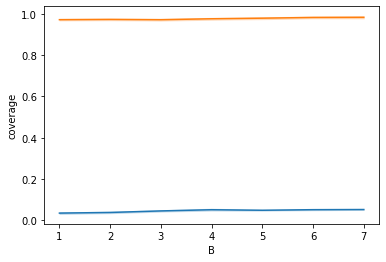

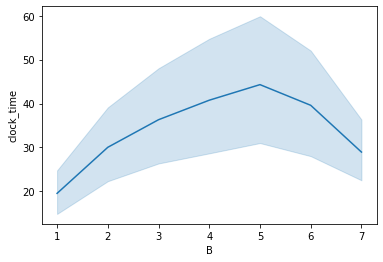

In [5]:
fig = sns.lineplot(x=df["B"], y=df["coverage"])
# plt.show()
fig = sns.lineplot(x=df["B"], y=df["precision"])
plt.show()
fig = sns.lineplot(x=df["B"], y=df["clock_time"])
plt.show()



In [6]:
df.lineplot(df[])

SyntaxError: invalid syntax (3383195146.py, line 1)